<a id='Q0'></a>
<center><a target="_blank" href="http://www.propulsion.academy"><img src="https://drive.google.com/uc?id=1McNxpNrSwfqu1w-QtlOmPSmfULvkkMQV" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

<center> <h1> Exercise: Classifiers I. Bank Marketing Data </h1> </center>
<p style="margin-bottom:1cm;"></p>

<center>Propulsion Academy, 2020</center>

**Use the bank direct marketing dataset to train a logistic regression (scikit-learn) predicting if a client will subscribe (1 or 0) to a term deposit (variable called ‘y’).**

Create a ML pipeline taking in account the following points:

   - Split your data into a train and test set.
   -  Use class_weight = ‘balanced’, as the dataset is unbalanced
   -  Use k-fold cross-validation to choose between L1- and L2-penalty or no penalty (you will have to specify penalty and C, logistic regression documentation). Use F1 score as a metric.

Once you have chosen the best model by cross-validation, evaluate its performance on the test set.

   - Calculate precision and recall.
   - Plot the ROC curve with varying thresholds.
   - Plot the precision vs recall (use the precision_recall_curve function from sklearn).
   
**Bonus**
   
   - Use the imblearn package to test different upsampling methods
   - Use k-fold cross validation for identifying the best upsampling method. Compare it with the class_weight = 'balanced' method.




Bank Marketing Data Set description: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing


    


## Import Libraries and define data path

In [1]:
%matplotlib inline
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
)
from sklearn.linear_model import LogisticRegression

# more info on ColumnTransformer here
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [3]:
plt.style.use("seaborn")

In [4]:
data_path = "../../data/banking.csv"

## Data inspection
Load the data and have a look at the basic properties.

In [5]:
df_raw = pd.read_csv(data_path)
df = df_raw.copy()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [6]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [7]:
df.shape

(41188, 21)

In [8]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

There are no missing values. So, no need to remove rows or impute values.

In [9]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


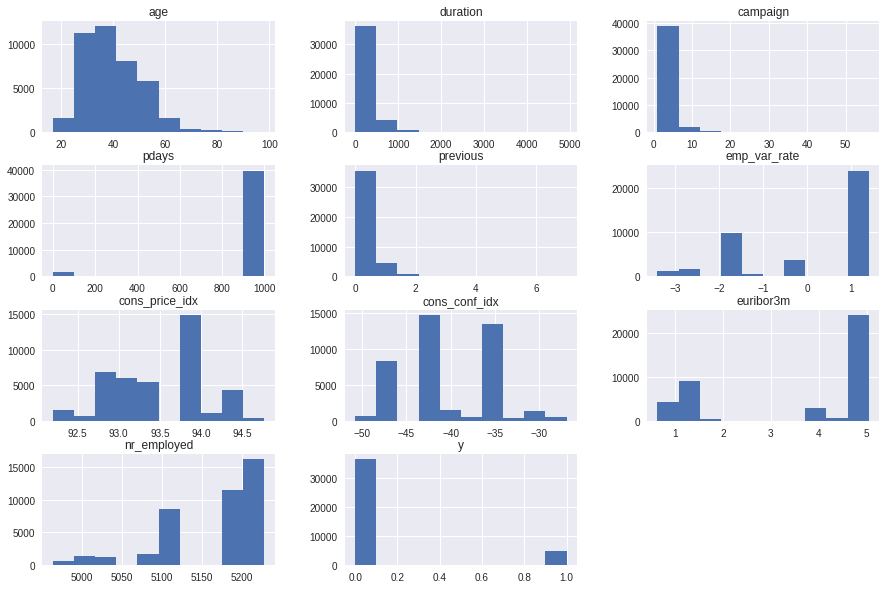

In [10]:
# This creats histograms for all numerical features
df.hist(figsize=(15, 10))
None

In [11]:
# Let's check the number of categories per categorical feature
df.select_dtypes(include=["object"]).apply(lambda col: len(col.unique()))

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [12]:
# Take a closer look at features with many categories
print(f"Job categories:\n{df['job'].unique()}\n")
print(f"Month categories:\n{df['month'].unique()}\n")
print(f"Education categories:\n{df['education'].unique()}")

Job categories:
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']

Month categories:
['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']

Education categories:
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']


In general, the categories look pretty clean. For the education categories we can combine the different levels of basic education to reduce the number of categories.

In [13]:
cat_replace = ["basic.6y", "basic.4y", "basic.9y"]
df["education"] = np.where(df["education"].isin(cat_replace), "Basic", df["education"])

## Data preparation

### Feature extraction 

Don't use the feature 'duration' for building a model since the description of this feature states: 

Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [14]:
# check the name of the columns
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [15]:
# get features and corresponding outcomes
df_clean = df.drop(columns=["duration"])
df_clean

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,Basic,unknown,no,no,telephone,may,thu,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


### Train-Test Split

We separate the dataset into train and test as follows in order to perform sampling later.   
Taking sample from the whole dataset (with 'y' included) is easier than taking it separately from X_train and y_train.  

In [16]:
df_train, df_test = train_test_split(
    df_clean, test_size=0.2, random_state=5, stratify=df_clean["y"]
)

### Split numerical and categorical features
For data preprocessing we have to separate numerical and categorical features. Different preprocessing steps are required for both type of features.

In [17]:
# list down features based on type
numeric_features = [
    "age",
    "campaign",
    "pdays",
    "previous",
    "emp_var_rate",
    "cons_price_idx",
    "cons_conf_idx",
    "euribor3m",
    "nr_employed",
]

categorical_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]

In [18]:
# Let's check the numerical features
df_train[numeric_features].dtypes

age                 int64
campaign            int64
pdays               int64
previous            int64
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
dtype: object

In [19]:
# Let's check the categorical features
df_train.iloc[:][numeric_features].isna().sum()

age               0
campaign          0
pdays             0
previous          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
dtype: int64

In [20]:
df_train.shape

(32950, 20)

In [21]:
# view updated feature set
df_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
40073,38,admin.,married,high.school,no,no,no,telephone,jun,mon,1,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
31709,48,services,single,high.school,unknown,no,yes,telephone,jun,tue,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0
9712,52,entrepreneur,married,university.degree,no,yes,no,cellular,nov,mon,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0
28391,33,services,married,Basic,no,no,no,telephone,may,wed,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
28826,39,unemployed,divorced,Basic,unknown,no,no,telephone,jun,fri,9,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0


### Scaling and encoding using a scikit-learn pipeline

Here we show how to apply different preprocessing and feature extraction pipelines for the case of dataset that contain heterogeneous data types, since we may want to **scale** the numeric features and **one-hot encode** the categorical ones.

Finally, the preprocessing pipeline is integrated in a full prediction pipeline using sklearn.pipeline.Pipeline, together with a Logistic Regression model.

In [22]:
# The numeric data is standard-scaled
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# while the categorical data is one-hot encoded
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# The column transformer allows to apply different preprocessing steps for individual sets of columns
# transformers must support fit and transform.
# Special-cased strings ‘drop’ and ‘passthrough’ are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Introduce Logistic Regression

Let's compare how Logistic Regression with no penalty, L1 and L2 penalties works

### No penalty 

In [23]:
# We use in this case solver = 'lbfgs' because it works for no penalty Logistic Regression
model_0 = LogisticRegression(
    class_weight="balanced", solver="lbfgs", penalty="none", max_iter=1000
)

#  implement pipeline
pipeline_nopenality = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_0)]
)

In [24]:
# check the cross validation score
n_samples = 1000
sample_train = df_train.sample(n_samples, random_state=42)

lr_nopenalty_score_f1 = np.mean(
    cross_val_score(
        pipeline_nopenality,
        sample_train.drop(columns="y"),
        sample_train["y"],
        cv=4,
        scoring="f1",
    )
)

lr_nopenalty_score_f1

0.28059499190656156

###  L1

In [25]:
# We use in this case solver = 'liblinear' because it is default and handles L1 penalty
# smaller C than default makes L1 regularization strong
model_1 = LogisticRegression(
    class_weight="balanced", solver="liblinear", penalty="l1", C=0.1
)

#  implement pipeline
pipeline_l1penality = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_1)]
)

In [26]:
np.mean(
    cross_val_score(
        pipeline_l1penality,
        sample_train.drop(columns="y"),
        sample_train["y"],
        cv=4,
        scoring="f1",
    )
)

0.34071170028533515

###  L2

In [27]:
# smaller C than default makes L2 regularization strong
model_2 = LogisticRegression(
    class_weight="balanced", solver="liblinear", penalty="l2", C=0.1, max_iter=1000
)
#  implement pipeline
pipeline_l2penality = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model_2)]
)

In [28]:
np.mean(
    cross_val_score(
        pipeline_l2penality,
        sample_train.drop(columns="y"),
        sample_train["y"],
        cv=4,
        scoring="f1",
    )
)

0.3704592087604059

## Cross-validation  and Model Selection
to choose between L1- and L2-penalty or no penalty 

In [29]:
# As we learned the 'C' parameter is an inverse to 'alpha', so we introduce alphas here
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

score_df_f1 = pd.DataFrame()
score_df_f1["alpha"] = alphas

### L1 Cross-Validation

In [30]:
model_l1 = LogisticRegression(
    class_weight="balanced", penalty="l1", solver="liblinear", max_iter=1000
)
pipeline_l1 = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model_l1)])

In [31]:
scores_l1 = []
for alpha in alphas:
    pipeline_l1.set_params(classifier__C=1 / alpha)
    score = np.mean(
        cross_val_score(
            pipeline_l1,
            sample_train.drop(columns="y"),
            sample_train["y"],
            cv=4,
            scoring="f1",
        )
    )
    scores_l1.append(score)
score_df_f1["L1"] = scores_l1

### L2 Cross-Validation

In [32]:
model_l2 = LogisticRegression(class_weight="balanced", penalty="l2", solver="liblinear")
pipeline_l2 = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model_l2)])

In [33]:
scores_l2 = []
for alpha in alphas:
    pipeline_l2.set_params(classifier__C=1 / alpha)
    score = np.mean(
        cross_val_score(
            pipeline_l2,
            sample_train.drop(columns="y"),
            sample_train["y"],
            cv=4,
            scoring="f1",
        )
    )
    scores_l2.append(score)
score_df_f1["L2"] = scores_l2

In [34]:
score_df_f1

,alpha,L1,L2
0,0.0001,0.280595,0.287251
1,0.0010,0.285887,0.285887
2,0.0100,0.285887,0.291486
3,0.1000,0.297674,0.304739
4,1.0000,0.327570,0.339443
5,10.0000,0.340712,0.370459
6,100.0000,0.321749,0.357371
7,1000.0000,0.000000,0.319409


In [35]:
score_df_f1.describe()

,alpha,L1,L2
count,8.000000,8.000000,8.000000
mean,138.888888,0.267509,0.319506
std,349.648809,0.110341,0.032953
min,0.000100,0.000000,0.285887
25%,0.007750,0.284564,0.290427
50%,0.550000,0.291781,0.312074
75%,32.500000,0.323204,0.343925
max,1000.000000,0.340712,0.370459


Select the best model by comparing 'f1' score.
You can also try different scoring parameter

Text(0, 0.5, 'f1 score')

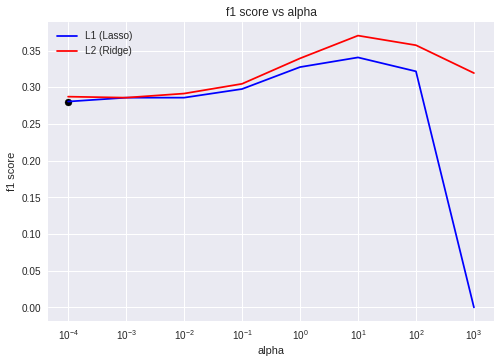

In [36]:
# Lasso
plt.semilogx(score_df_f1["alpha"], score_df_f1["L1"], color="blue", label="L1 (Lasso)")

# Ridge
plt.semilogx(score_df_f1["alpha"], score_df_f1["L2"], color="red", label="L2 (Ridge)")
plt.scatter(x=alphas[0], y=lr_nopenalty_score_f1, color="black")
plt.title("f1 score vs alpha")
plt.xlabel("alpha")
plt.legend()
plt.ylabel("f1 score")

Let's find out the maximum score and the best penalty

In [37]:
score_df_f1.L1.max(), score_df_f1.L2.max(), lr_nopenalty_score_f1

(0.34071170028533515, 0.3704592087604059, 0.28059499190656156)

Another way to check for the best score

In [38]:
score_df_f1.iloc[[score_df_f1.drop(columns=["alpha"]).stack().idxmax()[0]]]

,alpha,L1,L2
5,10.0,0.340712,0.370459


In [39]:
best_alpha = score_df_f1.iloc[
    [score_df_f1.drop(columns=["alpha"]).stack().idxmax()[0]]
].alpha.values[0]
best_penalty = [score_df_f1.drop(columns=["alpha"]).stack().idxmax()][0][1]
print("The best alpha and penalty are {} and {}".format(best_alpha, best_penalty))

The best alpha and penalty are 10.0 and L2


Other way to check for the worst score

In [40]:
score_df_f1.iloc[[score_df_f1.drop(columns=["alpha"]).stack().idxmin()[0]]]

,alpha,L1,L2
7,1000.0,0.0,0.319409


In [41]:
worst_alpha = score_df_f1.iloc[
    [score_df_f1.drop(columns=["alpha"]).stack().idxmin()[0]]
].alpha.values[0]
worst_penalty = [score_df_f1.drop(columns=["alpha"]).stack().idxmin()][0][1]
print(f"The worst alpha and penalty are {worst_alpha} and {worst_penalty}")

The worst alpha and penalty are 1000.0 and L1


As we can see, the nopenalty score is not the best and not the worst

## Modeling with the best selected model

### The Best model

In [42]:
X_train = sample_train.drop(columns="y")
y_train = sample_train["y"]

X_test = df_test.drop(columns="y")
y_test = df_test["y"]

In [43]:
print(f"Reminder: The best alpha and penalty are {best_alpha} and {best_penalty}")

Reminder: The best alpha and penalty are 10.0 and L2


In [44]:
pipeline_best_model = pipeline_l1.set_params(
    classifier__C=1 / best_alpha, classifier__penalty=best_penalty.lower()
)

# fit and view model parameters
pipeline_best_model.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'educ

Predictions with the best model

In [45]:
predictions_train = pipeline_best_model.predict_proba(X_train)[:, 1]
predictions_test = pipeline_best_model.predict_proba(X_test)[:, 1]
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, predictions_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, predictions_test)

### The Worst model

In [46]:
# worst score was with L1 regularization and alpha = 1000

pipeline_worst_model = pipeline_l1.set_params(
    classifier__C=1 / worst_alpha, classifier__penalty=worst_penalty.lower()
)

# fit and view model parameters
pipeline_worst_model.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp_var_rate',
                                                   'cons_price_idx',
                                                   'cons_conf_idx', 'euribor3m',
                                                   'nr_employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'educ

Predictions with the worst model

In [47]:
predictions_train_untuned = pipeline_worst_model.predict_proba(X_train)[:, 1]
predictions_test_untuned = pipeline_worst_model.predict_proba(X_test)[:, 1]
fpr_train_untuned, tpr_train_untuned, _ = metrics.roc_curve(
    y_train, predictions_train_untuned
)
fpr_test_untuned, tpr_test_untuned, _ = metrics.roc_curve(
    y_test, predictions_test_untuned
)

## Plotting

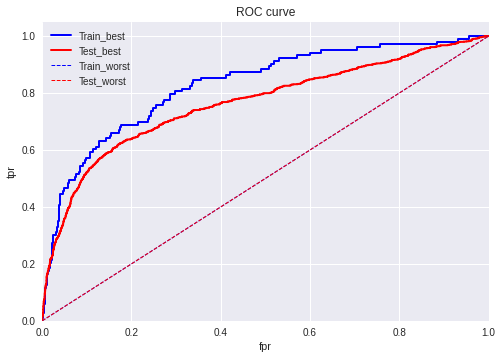

In [49]:
plt.plot(fpr_train, tpr_train, "b", linewidth=2, markersize=4, label="Train_best")
plt.plot(fpr_test, tpr_test, "r", linewidth=2, markersize=4, label="Test_best")
plt.plot(
    fpr_train_untuned,
    tpr_train_untuned,
    "b--",
    linewidth=1,
    markersize=4,
    label="Train_worst",
)
plt.plot(
    fpr_test_untuned,
    tpr_test_untuned,
    "r--",
    linewidth=1,
    markersize=4,
    label="Test_worst",
)
plt.xlabel("fpr")
plt.legend()
plt.ylabel("tpr")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("ROC curve")
None

--------------
# End of This Notebook